# Simulation study CE vs. EIS bias/variance/rho

## imports

In [1]:
import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as jrn
from functools import partial
from jaxtyping import Array, Float

import matplotlib.pyplot as plt
import pandas as pd

from isssm.lcssm import nb_lcssm, simulate_lcssm
from isssm.mode_estimation import mode_estimation
from isssm.modified_efficient_importance_sampling import modified_efficient_importance_sampling
from isssm.ce_method import (
    ce_cholesky_precision, 
    marginals,
    simulate as simulate_ce,
    ce_log_weights 
)
from isssm.importance_sampling import ess_pct
from isssm.importance_sampling import lcssm_importance_sampling
from isssm.kalman import kalman, smoother

2024-05-15 14:40:22.069195: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 14:40:22.069222: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 14:40:22.069229: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## simulation code

In [2]:
def eis_marginals(x0, A, Sigma, B, z, Omega):
    x_filt, Xi_filt, x_pred, Xi_pred = kalman(z, x0, Sigma, Omega, A, B)
    x_smooth, Xi_smooth = smoother(x_filt, Xi_filt, x_pred, Xi_pred, A)
    
    marg_means = x_smooth
    marg_vars = vmap(jnp.diag)(Xi_smooth)

    return marg_means, marg_vars

def eis_single_outcome(key, N_eis, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, subkey = jrn.split(key)
    z_eis, Omega_eis = modified_efficient_importance_sampling(
        Y, x0, A, Sigma, B, xi, dist, z_la, Omega_la, 1, N_eis, subkey
    )

    key, subkey = jrn.split(key)
    _, log_weights = lcssm_importance_sampling(
        Y, x0, A, Sigma, B, dist, xi, z_eis, Omega_eis, N_eis, subkey
    )

    return *(eis_marginals(x0, A, Sigma, B, z_eis, Omega_eis)), ess_pct(log_weights)

def ce_single_outcome(key, N_ce, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, subkey = jrn.split(key)
    
    samples, log_weights = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la, N_ce, subkey)

    (diag, off_diag, mean), _, _ = ce_cholesky_precision(Y, x0, A, Sigma, B, xi, dist, samples, log_weights, 1, N_ce, subkey)

    key, subkey = jrn.split(key)
    samples = simulate_ce(
        diag, off_diag, subkey, N_ce
    )

    log_weights = vmap(partial(ce_log_weights,
        y=Y, full_diag=diag, off_diag=off_diag, mean=mean, x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi
    ))(samples)

    return *(marginals(mean, diag, off_diag)), ess_pct(log_weights)

def bias_var(
    samples: Float[Array, "N ..."],
    true: Float[Array, "..."]
):
    bias_sr = (samples - true)**2
    var = (samples - samples.mean(axis=0)) ** 2
    return bias_sr, var

def eis_outcomes(N_eis, key, N_mse, true_z, true_Omega, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, *subkeys = jrn.split(key, N_mse+1)
    subkeys = jnp.array(subkeys)

    true_mean, true_var = eis_marginals(x0, A, Sigma, B, true_z, true_Omega)

    single_run = partial(eis_single_outcome, Y=Y, N_eis=N_eis, x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi, z_la=z_la, Omega_la=Omega_la)
    marg_means, marg_vars, ef = vmap(single_run)(subkeys)
        
    mean_bias, mean_var = bias_var(marg_means, true_mean)
    var_bias, var_var = bias_var(marg_vars, true_var)

    return pd.DataFrame({
        "N": int(N_eis),
        "N_mse": N_mse,
        "mean_bias": mean_bias.mean(axis=(-2, -1)),
        "mean_var": mean_var.mean(axis=(-2,-1)),
        "var_bias": var_bias.mean(axis=(-2,-1)),
        "var_var": var_var.mean(axis=(-2,-1)),
        "ef": ef,
    })

def ce_outcomes(N_ce, key, N_mse, true_mean, true_diag, true_off_diag, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, *subkeys = jrn.split(key, N_mse+1)
    subkeys = jnp.array(subkeys)

    true_mean, true_var = marginals(true_mean, true_diag, true_off_diag)

    single_run = partial(ce_single_outcome, N_ce=N_ce, Y=Y,x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi, z_la=z_la, Omega_la=Omega_la)

    marg_means, marg_vars, ef = vmap(single_run)(subkeys)
        
    mean_bias, mean_var = bias_var(marg_means, true_mean)
    var_bias, var_var = bias_var(marg_vars, true_var)

    return pd.DataFrame({
        "N": int(N_ce),
        "N_mse": N_mse,
        "mean_bias": mean_bias.mean(axis=(-2,-1)),
        "mean_var": mean_var.mean(axis=(-2,-1)),
        "var_bias": var_bias.mean(axis=(-2,-1)),
        "var_var": var_var.mean(axis=(-2,-1)),
        "ef": ef,
    })

## setup

In [3]:
x0 = jnp.zeros(1)
n = 20
alpha = .5
A = alpha * jnp.tile(jnp.eye(1)[None,:,:], (n, 1, 1))
Sigma = (1 - alpha ** 2) * jnp.tile(jnp.eye(1)[None,:,:], (n + 1, 1, 1))

# NB observations 

nb_model = nb_lcssm(
    x0,
    A,
    Sigma,
    jnp.tile(jnp.eye(1)[None, :,:], (n + 1, 1, 1)),
    .1
)
x0, A, Sigma, B, dist, xi = nb_model

key = jrn.PRNGKey(342234)
key, subkey = jrn.split(key)
(X,), (Y,) = simulate_lcssm(*nb_model, 1, subkey)

X_smooth, z_la, Omega_la = mode_estimation(Y, x0, A, Sigma, B, dist, xi, X, 10)

# more will result in OOMs
N_true = int(1.5 * 1e5)
N_mse = 100
Ns = jnp.logspace(1,3.5,10).astype(jnp.int32)

## LA simulation

In [4]:
key, subkey_run = jrn.split(key)

def la_single_outcome(key, N, Y, x0, A, Sigma, B, dist, xi, z, Omega):
    _, log_weights = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, z, Omega, N, key)
    return ess_pct(log_weights)

def la_outcomes(N_la, key, N_mse, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la):
    key, *subkeys = jrn.split(key, N_mse+1)
    subkeys = jnp.array(subkeys)

    single_run = partial(la_single_outcome, N=N_la, Y=Y,x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi, z=z_la, Omega=Omega_la)

    ef = vmap(single_run)(subkeys)

    return pd.DataFrame({
        "N": int(N_la),
        "N_mse": N_mse,
        "mean_bias": None,
        "mean_var": None,
        "var_bias": None,
        "var_var": None,
        "ef": ef,
    })

results_la = pd.concat([
    la_outcomes(N, subkey_run, N_mse, Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la)
    for N in Ns
]).reset_index(drop=True)

## EIS simulation

In [5]:
key, subkey = jrn.split(key)
true_z_eis, true_omega_eis = modified_efficient_importance_sampling(
    Y, x0, A, Sigma, B, xi, dist, z_la, Omega_la, 1, N_true, subkey,
)

In [6]:
single_N_run_eis = partial(
    eis_outcomes, 
    Y=Y, key=subkey_run, N_mse=N_mse, true_z=true_z_eis, true_Omega=true_omega_eis, x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi, z_la=z_la, Omega_la=Omega_la
)

results_eis = pd.concat([
    single_N_run_eis(N) for N in Ns
]).reset_index(drop=True)


## CE simulation

In [7]:
key, subkey = jrn.split(key)
samples_la, log_weights_la = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la, N_true, subkey)

key, subkey = jrn.split(key)
(true_diag, true_off_diag, true_mu), (_, log_weights_ce), _ = ce_cholesky_precision(Y, x0, A, Sigma, B, xi, dist, samples_la, log_weights_la, 1, N_true, subkey)

In [8]:
single_N_run_ce = partial(
    ce_outcomes, 
    Y=Y, key=subkey_run, N_mse=N_mse, true_mean=true_mu, true_diag=true_diag, true_off_diag=true_off_diag, x0=x0, A=A, Sigma=Sigma, B=B, dist=dist, xi=xi, z_la=z_la, Omega_la=Omega_la
)

results_ce = pd.concat([
    single_N_run_ce(N) for N in Ns
]).reset_index(drop=True)

## inspect true solutions

In [9]:
_, log_weights_eis = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, true_z_eis, true_omega_eis, N_true, subkey)
ess_pct(log_weights_la), ess_pct(log_weights_ce), ess_pct(log_weights_eis)

(Array(99.19363796, dtype=float64),
 Array(99.73211251, dtype=float64),
 Array(98.60006564, dtype=float64))

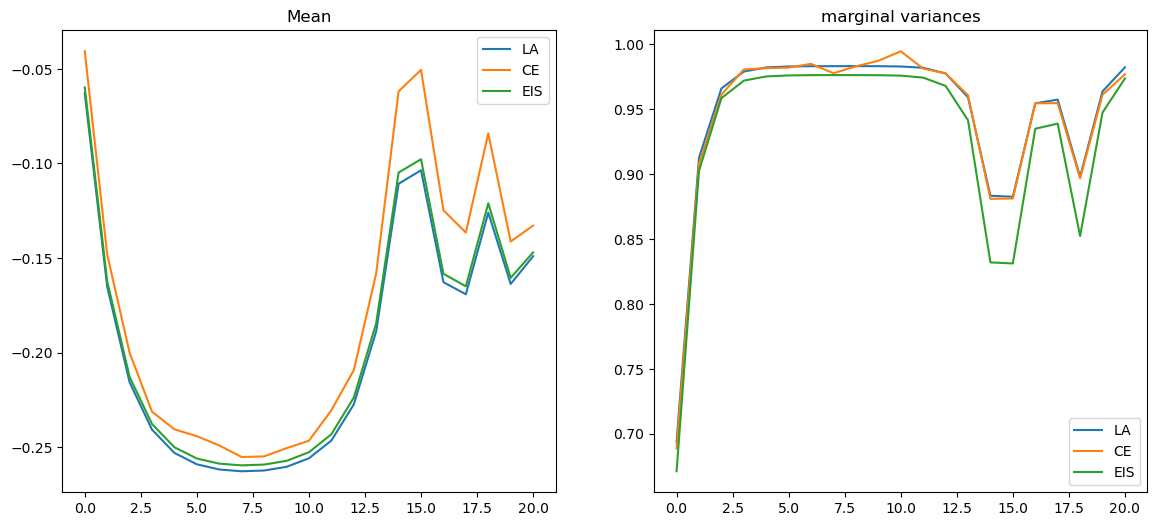

In [10]:
ce_true_mu, ce_true_var = marginals(true_mu, true_diag, true_off_diag)
eis_true_mu, eis_true_var = eis_marginals(x0, A, Sigma, B, true_z_eis, true_omega_eis)
la_mu, la_var = eis_marginals(x0, A, Sigma, B, z_la, Omega_la)


fig, axs = plt.subplots(1,2, figsize=(14,6))

axs[0].set_title("Mean")
axs[0].plot(la_mu[:,0], label="LA")
axs[0].plot(ce_true_mu[:,0], label="CE")
axs[0].plot(eis_true_mu[:,0], label="EIS")
axs[0].legend()
axs[1].set_title("marginal variances")
axs[1].plot(la_var[:,0], label="LA")
axs[1].plot(ce_true_var[:,0], label="CE")
axs[1].plot(eis_true_var[:,0], label="EIS")
axs[1].legend()
plt.show()

## simulation results

In [11]:
import seaborn as sns
results_eis

,N,N_mse,mean_bias,mean_var,var_bias,var_var,ef
0,10,100,2.376029e-06,1.323266e-05,7.073716e-05,1.197233e-04,99.388882
1,10,100,3.679463e-05,1.336297e-05,4.360925e-04,1.058926e-04,99.919367
2,10,100,3.726607e-05,7.752917e-06,3.206791e-04,9.473126e-05,99.884425
3,10,100,4.763048e-05,1.419563e-05,2.901827e-04,4.324263e-05,99.344105
4,10,100,1.264507e-05,2.187693e-06,2.562766e-04,2.556983e-05,98.119059
...,...,...,...,...,...,...,...
995,3162,100,3.289474e-08,5.387409e-08,8.355205e-08,6.368821e-08,98.571151
996,3162,100,1.041701e-06,1.173027e-06,1.789955e-06,1.911074e-06,98.633717
997,3162,100,1.291244e-07,8.925567e-08,3.740082e-07,3.048106e-07,98.598259
998,3162,100,7.938764e-07,7.009492e-07,1.041545e-06,9.187332e-07,98.606377


In [12]:
results = pd.concat([
    results_la.assign(method="LA"),
    results_eis.assign(method="EIS"), 
    results_ce.assign(method="CE")
])
results.to_csv("../../data/figures/03_state_space_models/compare_ce_eis_mse.csv", index=False)

/tmp/ipykernel_260345/409058690.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([


<Axes: xlabel='N', ylabel='ef'>

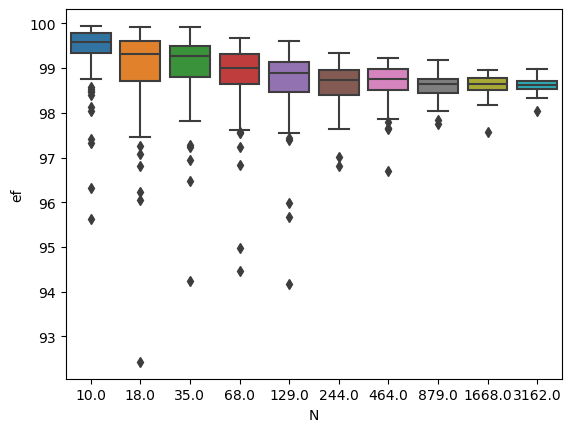

In [13]:
results_eis["N"] = results_eis["N"].astype(jnp.float64)
sns.boxplot(results_eis, x="N", y="ef")

## Optimum analysis: efficiency factors

In [7]:
df_ef = pd.DataFrame({
    "N": {},
    "method": {},
    "ef": {}
})
(n_iter_la, n_iter_eis, n_iter_ce) = (10, 10, 10)

key, *subkeys_large = jrn.split(key, 3)
subkeys_large = jnp.array(subkeys_large)

for subkey in subkeys_large:
    n = 10
    N_true = int(1.5 * 1e6 / n)
    x0 = jnp.zeros(1)
    alpha = .5
    A = alpha * jnp.tile(jnp.eye(1)[None,:,:], (n, 1, 1))
    Sigma = (1 - alpha ** 2) * jnp.tile(jnp.eye(1)[None,:,:], (n + 1, 1, 1))

    # NB observations 
    model = nb_lcssm(
        x0,
        A,
        Sigma,
        jnp.tile(jnp.eye(1)[None, :,:], (n + 1, 1, 1)),
        .1
    )
    #model = poisson_lcssm(
    #    x0,
    #    A,
    #    Sigma,
    #    jnp.tile(jnp.eye(1)[None, :,:], (n + 1, 1, 1)),
    #)
    x0, A, Sigma, B, dist, xi = model

    key, subkey = jrn.split(key)
    (X,), (Y,) = simulate_lcssm(*model, 1, subkey)
    X_smooth, z_la, Omega_la = mode_estimation(Y, x0, A, Sigma, B, dist, xi, X, n_iter_la)
    true_z_eis, true_omega_eis = modified_efficient_importance_sampling(
        Y, x0, A, Sigma, B, xi, dist, z_la, Omega_la, n_iter_eis, N_true, subkey,
    )

    _, log_weights_eis = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, true_z_eis, true_omega_eis, N_true, subkey)

    samples_la, log_weights_la = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la, N_true, subkey)

    key, subkey = jrn.split(key)
    _, (_, log_weights_ce), _ = ce_cholesky_precision(Y, x0, A, Sigma, B, xi, dist, samples_la, log_weights_la, n_iter_ce, N_true, subkey)

    df_ef = pd.concat([
            df_ef,
            pd.DataFrame({
                "N": N_true,
                "method": ["LA", "EIS", "CE"],
                "ef": [ess_pct(log_weights_la), ess_pct(log_weights_eis), ess_pct(log_weights_ce)]
            })
        ])
    
df_ef.to_csv("../../data/figures/03_state_space_models/ef_large_N.csv", index=False)

/tmp/ipykernel_552802/3756798560.py:49: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_ef = pd.concat([


In [8]:
from isssm.lcssm import poisson_lcssm
df_dimensions = pd.DataFrame({
    "N": {},
    "m": {},
    "n": {},
    "method": {},
    "ef": {}
})

(n_iter_la, n_iter_eis, n_iter_ce) = (10, 10, 10)

key, *subkeys_large = jrn.split(key, 3)
subkeys_large = jnp.array(subkeys_large)

ns = jnp.array([10, 20, 50, 100, 500, 1000])

for key in subkeys_large:
    for n in ns:

        # prevent OOM, smaller N for larger n
        N_true = int(1.5 * 1e6 / n)
        x0 = jnp.zeros(1)
        alpha = .5
        A = alpha * jnp.tile(jnp.eye(1)[None,:,:], (n, 1, 1))
        Sigma = (1 - alpha ** 2) * jnp.tile(jnp.eye(1)[None,:,:], (n + 1, 1, 1))

        # NB observations 
        model = nb_lcssm(
            x0,
            A,
            Sigma,
            jnp.tile(jnp.eye(1)[None, :,:], (n + 1, 1, 1)),
            .1
        )
        #model = poisson_lcssm(
        #    x0,
        #    A,
        #    Sigma,
        #    jnp.tile(jnp.eye(1)[None, :,:], (n + 1, 1, 1)),
        #)
        x0, A, Sigma, B, dist, xi = model

        key, subkey = jrn.split(key)
        (X,), (Y,) = simulate_lcssm(*model, 1, subkey)
        X_smooth, z_la, Omega_la = mode_estimation(Y, x0, A, Sigma, B, dist, xi, X, n_iter_la)

        key, subkey = jrn.split(key)
        true_z_eis, true_omega_eis = modified_efficient_importance_sampling(
            Y, x0, A, Sigma, B, xi, dist, z_la, Omega_la, n_iter_ce, N_true, subkey,
        )

        key, subkey = jrn.split(key)
        samples_la, log_weights_la = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, z_la, Omega_la, N_true, subkey)
        _, log_weights_eis = lcssm_importance_sampling(Y, x0, A, Sigma, B, dist, xi, true_z_eis, true_omega_eis, N_true, subkey)
        _, (_, log_weights_ce), _ = ce_cholesky_precision(Y, x0, A, Sigma, B, xi, dist, samples_la, log_weights_la, n_iter_ce, N_true, subkey)

        df_dimensions = pd.concat([
                df_dimensions,
                pd.DataFrame({
                    "N": N_true,
                    "m": 1,
                    "n": n,
                    "method": ["LA", "EIS", "CE"],
                    "ef": [ess_pct(log_weights_la), ess_pct(log_weights_eis), ess_pct(log_weights_ce)]
                })
            ])
        
df_dimensions.to_csv("../../data/figures/03_state_space_models/ef_dimensions.csv", index=False)

/tmp/ipykernel_552802/411855959.py:57: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_dimensions = pd.concat([
